In [2]:
"""
This script provides several user defined functions and examples of how to analyse solar wind and magnetic field data from the OMNIWeb data explorer 
and combine it with events detected with MISS-1 and MISS-2. 

Possible analyses include extracting solar wind parameters at the moment of auroral events. Scatter plots or heatmaps showing the distribution of 
detected auroral events together with the daily average of solar wind parameters. Calculating averages or standard deviations in solar wind parameters.

The OMNIWeb data explorer can be found at: https://omniweb.gsfc.nasa.gov/form/dx1.html (if still available... boo Trump)

NOTE
- Functions in this script are based on data from OMNIWeb that is exported as 5 min averaged!
- This can, if desired, easily be adapted to 1 min averaged

Created on May 9 2025

@author: Tim Hulsen
"""

import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths, medfilt2d
import warnings
import re
import datetime
import shutil
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.patches as patches

### Import & reshape OMNIWeb data

In [3]:
"""
OMNIWeb data is downloaded in text files for a selected range of time. 
It has the following format:

Column 1: Year
Column 2: Day of year (1 - 365)
Column 3: Hour of day (0 - 23)
Column 4: Minute of hour (0 - 59)
Column 5: Parameter 1
Column 6: Parameter 2
....

The first four columns have the same format for each file. In case of 5 min averaged data the minute column only consists of multiples of 5.
Column 5 and any additional columns contain the data of selected parameters. 
- CHECK THE FORMAT FILE TO SEE WHICH COLUMN CORRESPONDS TO WHAT PARAMETER!

Since MISS-1 and MISS-2 data is concentrated around the winter seasons there is roughly 6 months of no data between seasons.
It is advised to export one OMNIWeb text file for each season if it is combined with MISS data. 

For this script we use data from 30 October 2024 to 25 February 2025 as an example.
"""

# 5 min averaged data from 30-10-2024 to 25-02-2025

# Save timestamps OMNIWEB data
# Column 0: Year
# Column 1: Day of year
# Column 2: Hour
# Column 3: Minute

dates_omni = np.loadtxt('Example files\\Omni_241030_250215_w_ptemp.txt', usecols=range(0,4))

# Load OMNIWEB data parameters
# Column 0: IMF magnitude(nT)
# Column 1: Bz (nT)
# Column 2: Solar wind speed (km/s)
# Column 3: Proton density (n/cc)
# Column 4: Proton temperature (Kelvin)
# Column 5: SYM/H (nT) "dst index"

data_omni = np.loadtxt('Example files\\Omni_241030_250215_w_ptemp.txt', usecols=range(4,10))

In [4]:
def reshape_OMNI(data_parameter, temp=False):

    """
    This function accepts a 1D list consisting of a single parameter from the imported OMNIWeb data.
    
    There exist outliers in the OMNIWEB data, recognizable as floats with only the number 9. The magnitude of the outliers differs per parameter. 
    In the current example the smallest outlier has a magnitude of 999.9, which is larger than the valid data of most parameters used in this example.
    Only the proton temperature uses values of higher magnitude. 
    For all parameters, except the proton temperature, values are changed to nan when larger than 999.9. In the input, temp should be set to True when 
    the proton temperature is considered to change the magnitude of outliers to 9999999.

    - Check what the values of outliers are and change this function when using different parameters!

    This function returns 2D arrays. Each row consists of one day of data. The number of columns depends on the time resolution.
    """

    # Convert list to numpy array
    data = np.array(data_parameter)

    # Convert outliers to nan
    if temp:
        outlier_index = np.where(data == 9999999.)
    else:
        outlier_index = np.where(data > 999.9)
    data[outlier_index] = np.nan

    # The example data is 5 min averaged
    # Reshape to 288 columns, equal to the number of values per day (24 hours * 60/5 values per hour)
    data_5min_avg_reshaped = data.reshape(-1,288)

    # Example how to average data in a smaller time resolution
    # Because the data is 5-min averaged there are 12 values per hour
    # We reshape the array to divide each hour into one row (12 columns)
    data_reshaped = data.reshape(-1,12)

    # Now we can calculate the mean for each hour, not including the nan values
    data_hour_avg = np.nanmean(data_reshaped, axis=1)

    # You can also calculate the standard deviation for each hour, not including the nan values
    # data_hour_std = np.nanstd(data_reshaped, axis=1)

    # Reshape the array in 24 columns such that there is one row for each day
    data_hour_avg_reshaped = data_hour_avg.reshape(-1,24)
    #data_hour_std_reshaped = data_hour_std.reshape(-1,24)

    return data_5min_avg_reshaped, data_hour_avg_reshaped

In [5]:
"""
Example with solar wind speed data.
Note that warnings can be triggered when an hourly average includes only nan values. These warnings can be ignored.

In this example the imported data consists of 109 days, as can be seen in the number of rows.
"""
# Select solar wind speed data from array
sol_wind = data_omni[:,2]
sol_wind_5min_avg_reshaped, sol_wind_hour_avg_reshaped = reshape_OMNI(sol_wind)

# Check shape of arrays
np.shape(sol_wind_5min_avg_reshaped), np.shape(sol_wind_hour_avg_reshaped)

C:\Users\20192027\AppData\Local\Temp\ipykernel_5620\4283372587.py:37: RuntimeWarning: Mean of empty slice
  data_hour_avg = np.nanmean(data_reshaped, axis=1)


((109, 288), (109, 24))

### Create overview of data

In [6]:
"""
In this part we create an overview of reshaped OMNIWeb data.
Datetime objects are used to label the x-axis in days and y-axis in time of day.
"""

# Create list of dates for the x-axis
start_date = datetime.datetime(2024, 10, 30)

# We want the next 109 days, the value K
K = 109
days = [start_date + datetime.timedelta(days=idx) for idx in range(K)]

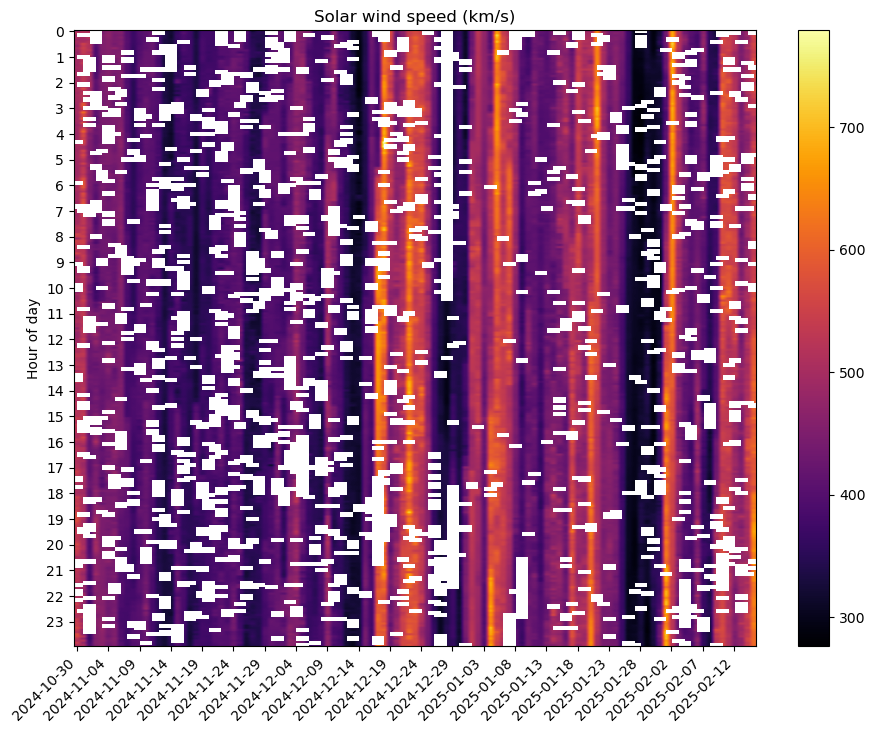

In [98]:
"""
Example of a heatmap of solar wind data.
"""

fig, ax = plt.subplots(figsize=(11,8))

# Create heatmap
# Transpose array to get days on the x-axis
pos=ax.imshow(np.transpose(sol_wind_5min_avg_reshaped), cmap='inferno', aspect='auto')
fig.colorbar(pos)

# Set the x-axis tick positions to show every ... label
tick_positions = np.arange(0,len(days),5)
ax.set_xticks(tick_positions)
# Set the y-axis ticks to show every full hour
ax.set_yticks(np.arange(0,288,12))
ax.set_yticklabels(np.linspace(0,23,24,dtype=int))

# Set the x-axis tick labels to the datetime objects at the specified positions
ax.set_xticklabels([days[i].strftime('%Y-%m-%d') for i in tick_positions], rotation=45, ha='right')

ax.set_ylabel("Hour of day")
ax.set_title("Solar wind speed (km/s)");

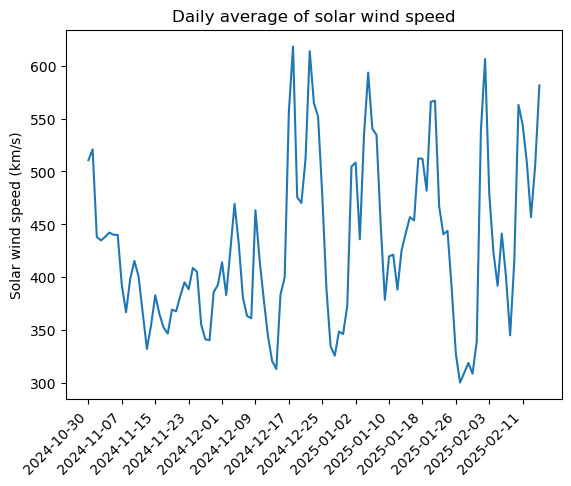

In [38]:
"""
With the data in its current format it is straightforward to compute, for example, the daily average.
"""

day_avg_sol_wind = np.nanmean(sol_wind_5min_avg_reshaped, axis=1)

fig, ax = plt.subplots()
ax.plot(day_avg_sol_wind)

tick_positions = np.arange(0,len(days),8)
ax.set_xticks(tick_positions)
ax.set_xticklabels([days[i].strftime('%Y-%m-%d') for i in tick_positions], rotation=45, ha='right')

ax.set_ylabel("Solar wind speed (km/s)")

ax.set_title("Daily average of solar wind speed");

### Overlay data with filtered events MISS

OMNIWeb data can be paired with auroral events by extracting the datetime object of MISS or corresponding Sony camera filenames.
Here the hand-filtered Sony images are used to extract the datetime of auroral events. Times are rounded to 5 minutes to match with OMNIWeb data.

In [39]:
# It is possible that Sony images have two different formats
# This function ensures that the same format is used
def convert_filename(filename):
    # Check if the filename is already in YYYYMMDD format
    if re.search(r'\d{8}_\d{6}', filename):
        return filename  # Return as is

    # Match DDMMYY format in the filename
    match = re.search(r'(\d{2})(\d{2})(\d{2})_(\d{6})', filename)
    if match:
        dd, mm, yy, time = match.groups()
        yyyy = f"20{yy}" 
        new_date = f"{yyyy}{mm}{dd}"
        new_filename = filename.replace(f"{dd}{mm}{yy}_{time}", f"{new_date}_{time}")
        return new_filename

    return filename  # Return unchanged if no match

In [47]:
image_files = []
years = ['2024','2025']
for year in years:
    # Example of reading Sony filenames per population
    # Possible to combine files from all populations and both MISS-1 and MISS-2
    image_dir = os.path.join(your_local_sony_storage,'Population 1 - hand filtered',year)
    image_files = image_files + [convert_filename(f) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir,f))]

In [76]:
# Convert timestamps Sony files to 5 min averaged
def convert_5min_average(filename):
    """
    Accepts Sony images in the format LYR-Sony-YYYYMMDD_HHMMSS.jpg
    Rounds the number of minutes to a multiple of 5 and compensates if the next full hour or day is reached.
    Number of seconds is neglected.

    Returns datetime objects.
    """
    
    time_format = re.search(r'(\d{4})(\d{2})(\d{2})_(\d{2})(\d{2})\d{2}', filename)
    if time_format:
        year, month, day, hour, minute = time_format.groups()

        # Round minutes to a multiple of 5
        new_minute = round(int(minute)/5)*5
        # If rounded to 60 convert to next full hour
        if new_minute == 60:
            hour = int(hour) + 1
            new_minute = 0

        # In the case that the next full hour is 24 we have to convert to the next day
        if hour == 24:
            day = int(day) + 1
            datetime_5min_rounded = datetime.datetime(int(year), int(month), day, 0, new_minute)
        else:
            timestamp_5min_rounded = datetime.datetime(int(year), int(month), int(day), int(hour), new_minute)

    return timestamp_5min_rounded

In [77]:
"""
These two lines of code result in a list of unique datetime objects corresponding with the imported Sony images.
The list is sorted to unique objects because the time resolution of MISS-1 and MISS-2 is higher than a 5 min average, resulting in multiple events
for a single datetime object, which can result in problems with overlaying events on e.g. a heatmap.

Ofcourse the files_5min_rounded list can be used to perform computations to find out how many events are detected for a single unique datetime object.
"""

# Convert Sony filenames
files_5min_rounded = [convert_5min_average(f) for f in image_files]

# Sort to unique datetime objects
unique_files_5min_rounded = sorted(set(files_5min_rounded))

In [93]:
"""
Here we calculate the position on the x-axis and y-axis for each event. The x-axis position is found by finding the list index in the 'days' list.
The y-axis position is found by counting the number of 5 minutes that have passed. 

NOTE
- a seperate list of datetime objects can be made by hand for continuum events, this makes it easier to identify them in calculations or a figure
"""

# Find the row in the OMNIWeb data that corresponds to the day of year of each event
# Equal to the position of each event along the x-axis in figures
x_index = [np.where(np.array(days) == datetime.datetime(time.year, time.month, time.day))[0][0] for time in unique_files_5min_rounded]

# Calculate which column in the OMNIWeb data corresponds to the multiple of 5 minutes of each event
# Equal to the position of each event along the y-axis in figures
y_index = [time.hour*12 + round(int(time.minute/5)) for time in unique_files_5min_rounded]

In [96]:
def omni_heatmap_overlayed(data_reshaped, col_index_omni):

    """
    Function to create a heatmap of a OMNIWeb parameter with an overlay of events detected with MISS.
    
    Input the reshaped data of a 5 min averaged parameter from the OMNIWeb array.
    Also input the column index of the parameter, used to set the title of figure.

    The x_index and y_index lists are used as global parameters to create the overlay.
    """

    fig, ax = plt.subplots(figsize=(11,8))
    
    pos=ax.imshow(np.transpose(data_reshaped), cmap='inferno', aspect='auto')
    fig.colorbar(pos)
    
    # Set the x-axis tick positions to show every ... label
    tick_positions = np.arange(0,len(days),5)
    ax.set_xticks(tick_positions)
    # Set the y-axis ticks to show every full hour
    ax.set_yticks(np.arange(0,288,12))
    ax.set_yticklabels(np.linspace(0,23,24,dtype=int))
    
    # Set the x-axis tick labels to the datetime objects at the specified positions
    ax.set_xticklabels([days[i].strftime('%Y-%m-%d') for i in tick_positions], rotation=45, ha='right')
    
    # Define the elements to highlight (row, column)
    elements_to_highlight = zip(y_index, x_index)
    #elements_to_highlight_continuum = zip(y_index_continuum, x_index_continuum)
    
    # Highlight the specified elements by drawing rectangles around them
    # NOTE that the final color is shown when multiple rectangles are plotted for one element !!!
    for (row, col) in elements_to_highlight:
        rect = patches.Rectangle((col - 0.5, row - 0.5), 1, 1, linewidth=1, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)
    #for (row, col) in elements_to_highlight_continuum:
    #    rect = patches.Rectangle((col - 0.5, row - 0.5), 1, 1, linewidth=1, edgecolor='red', facecolor='none')
    #    ax.add_patch(rect)
        
    ax.set_ylabel("Hour of day")

    title_of_data = ["IMF magnitude (nT)", "Bz (nT)", "Solar wind speed (km/s)", "Proton density (n/cc)", "Proton temperature (K)", "SYM/H (nT)"] 
    ax.set_title(title_of_data[col_index_omni]);

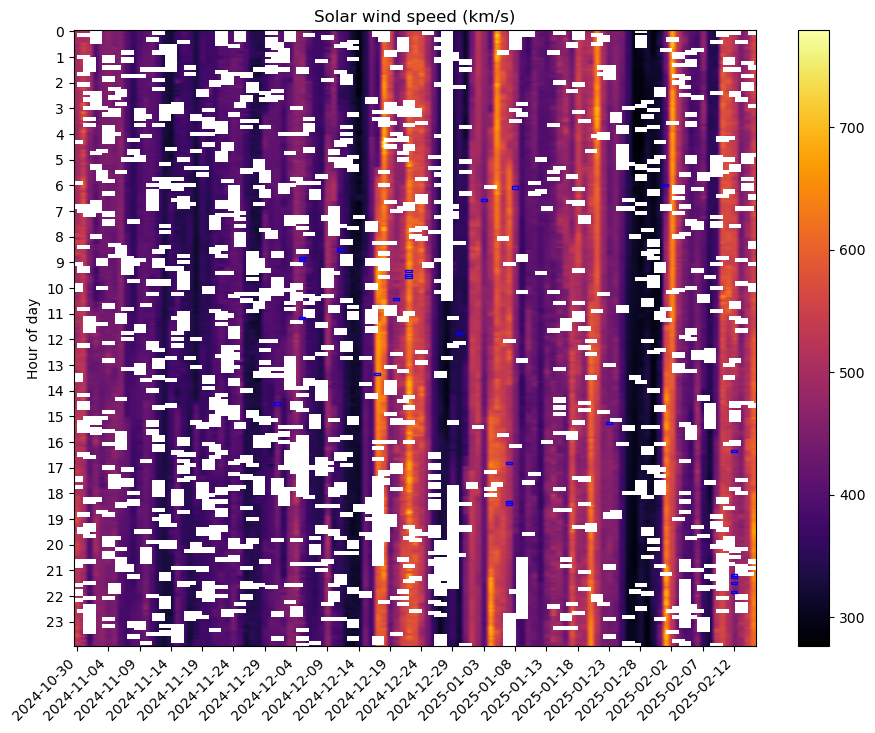

In [97]:
omni_heatmap_overlayed(sol_wind_5min_avg_reshaped, 2)

In [103]:
def omni_scatter_of_overlay_day_avg(data_reshaped, col_index_omni):
    fig = plt.figure()

    # Select data from reshaped OMNIWeb parameter matching with time of auroral events
    data_events = [data_reshaped[col,row] for (row, col) in zip(y_index, x_index)]
    #data_continuum = [data_reshaped[col,row] for (row, col) in zip(y_index_continuum, x_index_continuum)]
    
    plt.scatter(x_index, data_events, color='blue')
    #plt.scatter(x_index_continuum, data_continuum, color='red')

    # Add the daily average of OMNIWeb parameter to figure
    average_per_day = np.nanmean(data_reshaped,axis=1)
    plt.plot(average_per_day, color='black')

    # Set the x-axis tick positions to show every ... label
    # Set the x-axis tick labels to the datetime objects at the specified positions
    tick_positions = np.arange(0,len(days),8)
    plt.xticks(ticks = tick_positions, labels = [days[i].strftime('%Y-%m-%d') for i in tick_positions], rotation=45, ha='right')
    
    title_of_data = ["IMF magnitude (nT)", "Bz (nT)", "Solar wind speed (km/s)", "Proton density (n/cc)", "Proton temperature (K)", "SYM/H (nT)"] 
    plt.ylabel(title_of_data[col_index_omni])

    #plt.legend(("All events", "Continuum event"), bbox_to_anchor=((1.0,1.0)))
    
    plt.grid();

    # Print the average and standard deviation of the OMNIWeb parameter at the time of auroral events
    print(f"The average for all events is {round(np.nanmean(data_events),1)} +- {round(np.nanstd(data_events),1)}")
    #print(f"The average for the continuum events is {round(np.nanmean(data_continuum),1)} +- {round(np.nanstd(data_continuum),1)}")

The average for all events is 486.2 +- 83.0


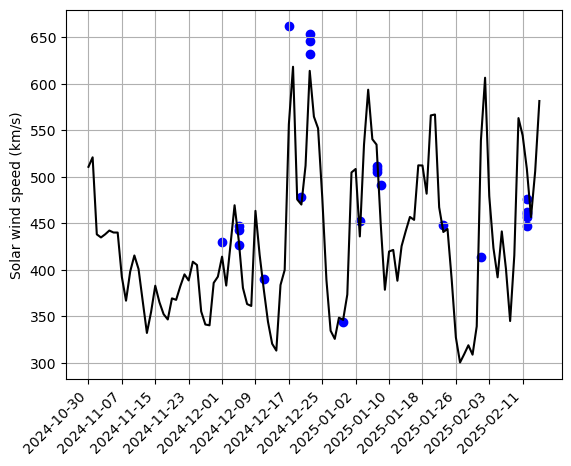

In [104]:
omni_scatter_of_overlay_day_avg(sol_wind_5min_avg_reshaped, 2)

In [ ]:
"""
Want to combine multiple periods/seasons of OMNIWeb data?

Below is an example of a figure where scatter plots such as shown above are placed next to each other without spacing. 
Each period of OMNIWeb data and corresponding 'days' are stored in a dictionary. 

NOTE
- the omni_scatter_of_overlay_day_avg function should be adapted for this code to also use dictionaries for the x_index and y_index lists.
- Sony images do not have to ordered by hand into their respective period of OMNIWeb data, this can easily be done in code by the same procedure used 
for a single period. Loop over all periods and remove empty entries.

"""
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=(15, 4), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1], 'wspace': 0})
axes = (ax1, ax2, ax3, ax4, ax5)

for (ax, key) in zip(axes, list(omni_data_dictionary.keys())[1:]):
    omni_scatter_of_overlay_day_avg(ax, sol_wind_5min_avg_reshaped[key], key, 2, days)

# Convert dates to indices for uniform spacing
date_sets = [days["Interval 2"],days["Interval 3"],days["Interval 4"],days["Interval 5"],days["Interval 6"]]
x_indices = [np.arange(len(dates)) for dates in date_sets]

# Define equal tick spacing
num_ticks = 6
for ax, dates, x_vals in zip(axes, date_sets, x_indices):
    tick_positions = np.linspace(0, len(x_vals) - 1, num_ticks, dtype=int)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([dates[i].strftime('%Y-%m-%d') for i in tick_positions], rotation=45, ha='right')

d = .015
for ax in [ax1, ax2, ax3, ax4, ax5]:
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((1-d, 1+d), (-d, +d), **kwargs)
    ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)